<a href="https://colab.research.google.com/github/hdyzute/sale-price-prediction-intervals/blob/main/house_price_prediction_quantile_regression_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [5]:
# Đọc dữ liệu
df = pd.read_csv("dataset.csv", parse_dates=["sale_date"])
y = df["sale_price"]
X = df.drop(columns=["sale_price"])

In [6]:
# Tách tập train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
# Xử lý sale_date thành nhiều feature
def encode_sale_date(df):
    df = df.copy()
    df["sale_year"] = df["sale_date"].dt.year
    df["sale_month"] = df["sale_date"].dt.month
    df["sale_week"] = df["sale_date"].dt.isocalendar().week.astype(int)
    df["sale_dayofweek"] = df["sale_date"].dt.dayofweek
    return df.drop(columns=["sale_date"])

date_transformer = FunctionTransformer(encode_sale_date)

In [8]:
# Xác định loại cột
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
date_cols = ["sale_date"]

In [9]:
# Pipeline cho số
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

# Pipeline cho categorical
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),   # xử lý NaN trước
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [10]:
# Kết hợp bằng ColumnTransformer
preprocessor = ColumnTransformer([
    ("date", date_transformer, date_cols),
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

In [17]:
# Hàm train & predict với GradientBoosting
def train_and_predict(X_train, y_train, X_val):
    # Pipeline + model
    def make_model(loss, alpha=None):
        params = {"loss": loss, "random_state": 0}
        if alpha is not None:
            params["alpha"] = alpha
        return Pipeline([
            ("preprocessor", preprocessor),
            ("model", GradientBoostingRegressor(**params))
        ])

    model_lower = make_model("quantile", alpha=0.05)
    model_upper = make_model("quantile", alpha=0.95)
    model_median = make_model("squared_error")

    model_lower.fit(X_train, y_train)
    model_upper.fit(X_train, y_train)
    model_median.fit(X_train, y_train)

    pred_lower = model_lower.predict(X_val)
    pred_upper = model_upper.predict(X_val)
    pred_median = model_median.predict(X_val)

    return pred_lower, pred_upper, pred_median, model_lower, model_upper, model_median

In [18]:
# Winkler score
def winkler_score(y_true, lower, upper, alpha=0.1, return_coverage=False):
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)
    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)
    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)
    if return_coverage:
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage
    return np.mean(score)

In [19]:
# Train và evaluate
pred_lower, pred_upper, pred_median, model_lower, model_upper, model_median = train_and_predict(X_train, y_train, X_val)

winkler, coverage = winkler_score(y_val, pred_lower, pred_upper, alpha=0.1, return_coverage=True)
rmse = np.sqrt(mean_squared_error(y_val, pred_median))

In [20]:
print(f"Winkler Score: {winkler:.2f}")
print(f"Coverage: {coverage:.2%}")
print(f"RMSE (median prediction): {rmse:.2f}")

Winkler Score: 508069.79
Coverage: 89.91%
RMSE (median prediction): 146034.21


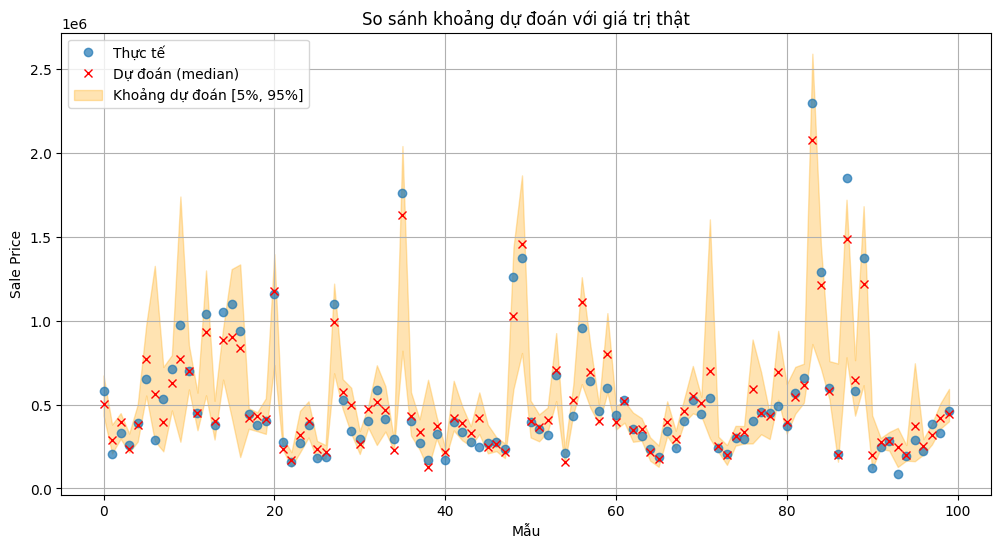

In [21]:
import matplotlib.pyplot as plt

# Chọn một phần dữ liệu để hiển thị
n_samples = 100
idx = np.arange(min(n_samples, len(y_val)))

plt.figure(figsize=(12, 6))

# Giá trị thật
plt.plot(idx, y_val.iloc[idx], "o", label="Thực tế", alpha=0.7)

# Dự đoán trung vị
plt.plot(idx, pred_median[idx], "x", label="Dự đoán (median)", color="red")

# Khoảng dự đoán
plt.fill_between(idx, pred_lower[idx], pred_upper[idx], color="orange", alpha=0.3, label="Khoảng dự đoán [5%, 95%]")

plt.xlabel("Mẫu")
plt.ylabel("Sale Price")
plt.title("So sánh khoảng dự đoán với giá trị thật")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
test_df = pd.read_csv("test.csv", parse_dates=["sale_date"])

test_pred_lower = model_lower.predict(test_df)
test_pred_upper = model_upper.predict(test_df)
test_pred_median = model_median.predict(test_df)

print("Dự đoán giá bán (lower bound) trên tập test:")
print(test_pred_lower[:10])

print("\nDự đoán giá bán (upper bound) trên tập test:")
print(test_pred_upper[:10])

print("\nDự đoán giá bán (median) trên tập test:")
print(test_pred_median[:10])

Dự đoán giá bán (lower bound) trên tập test:
[674564.16631308 439203.11853278 345394.34680963 307254.59465743
 245597.37207798 500245.56967436 401738.12368314 304984.98637707
 367889.90801775 334077.89718841]

Dự đoán giá bán (upper bound) trên tập test:
[1127912.73248928  746606.6308153   989382.9587726   508253.75062163
 1015931.25160106 1088347.79225228  750367.00432932  452397.79720587
  571077.52872554  669946.90044689]

Dự đoán giá bán (median) trên tập test:
[905612.46981535 690151.59830146 486355.0306231  417409.45601239
 658930.97840716 907653.96149335 539687.95318336 360967.8084965
 448043.6167871  490866.535837  ]


In [25]:
submission = pd.DataFrame({
    "id": test_df['id'],
    "pi_lower": test_pred_lower,
    "pi_upper": test_pred_upper
})

submission.to_csv("submission.csv", index=False)

print("Đã tạo file submission.csv thành công!")

Đã tạo file submission.csv thành công!
